In [1]:
import numpy as np
import matplotlib.pyplot as plt

# from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
# from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## Read Dataset

In [2]:
fname = 'GuangzhouPM20100101_20151231.csv'
usecols = ['HUMI', 'PRES', 'Iws', 'Iprec']

rec_raw = np.genfromtxt(fname, 
                delimiter=',',
                names=True,
                dtype=np.float64,
                usecols=usecols,
                )

rec = rec_raw.copy()

rec_raw.shape

(52584,)

## Visualization

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


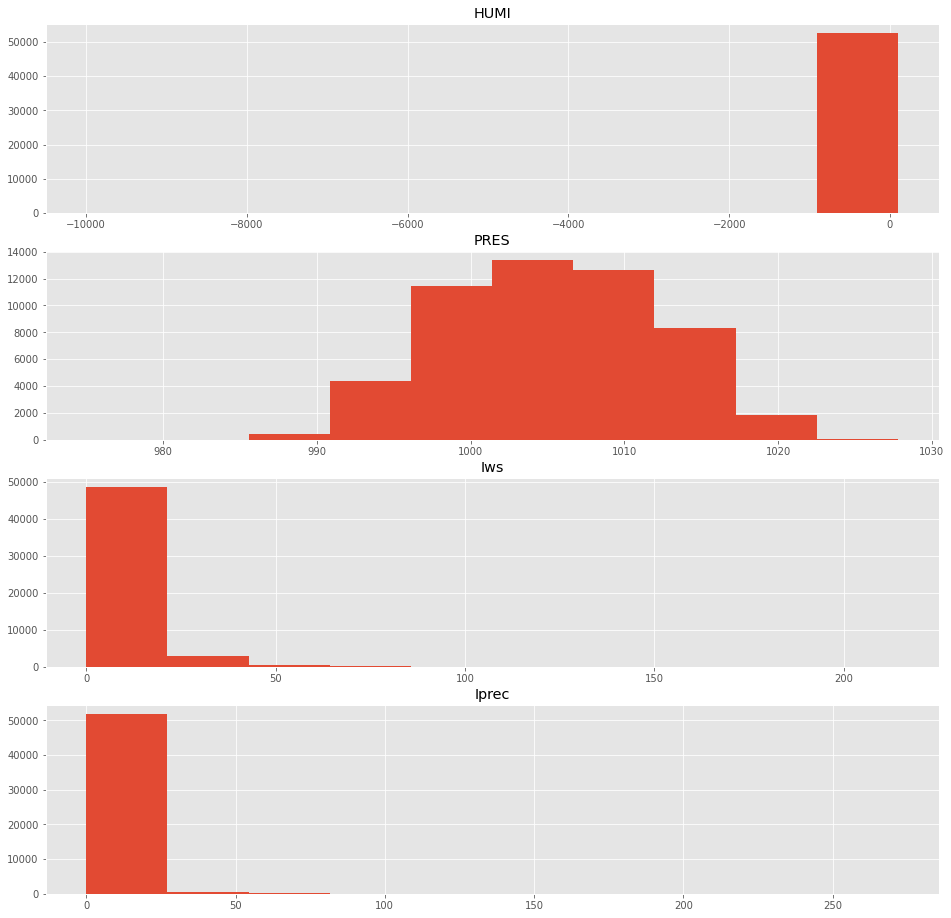

In [3]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

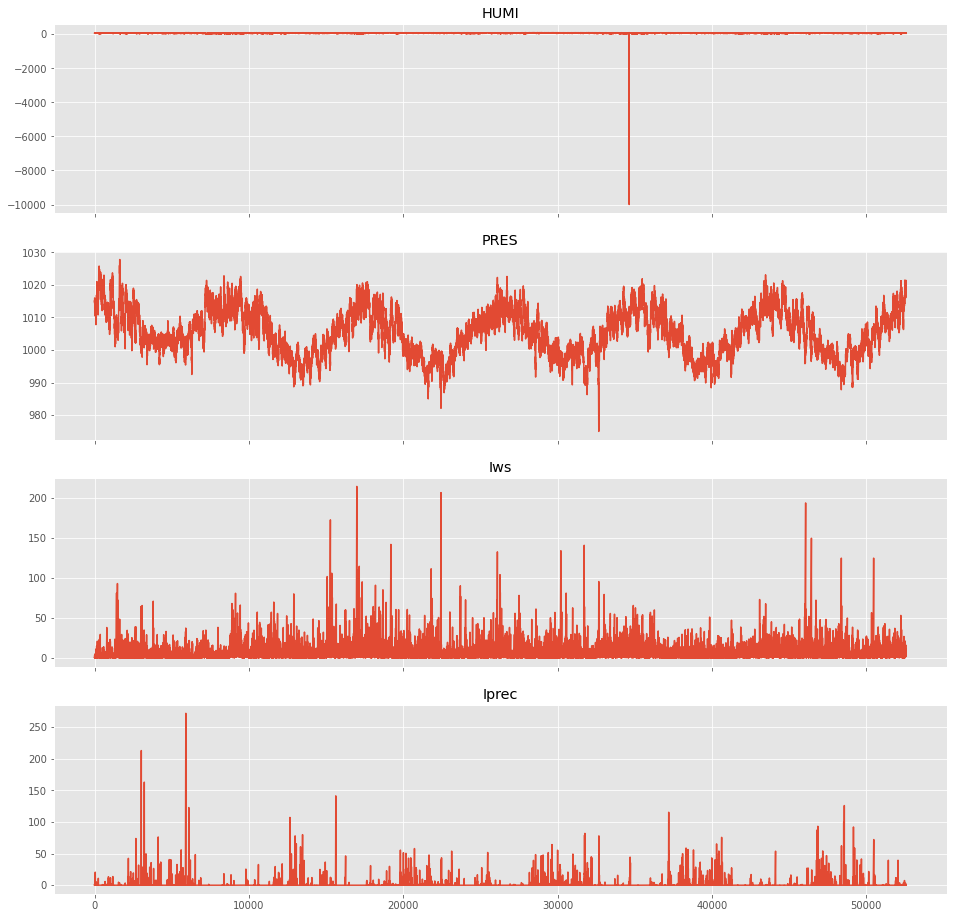

In [4]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [5]:
# Pair Plot in matplotlib

## Drop Duplicate & NaN

In [6]:
rec = np.unique(rec_raw, axis=0)

rec.shape

(51794,)

In [7]:
view = rec.view(np.float64).reshape(-1, rec.dtype.__len__())
rec = rec[np.any(~np.isnan(view), axis=1)]

rec.shape

(51793,)


## Interpolation

In [8]:
for i, col in enumerate(rec.dtype.names):
    indices = np.arange(rec[col].shape[0])
    not_nan = ~np.isnan(rec[col])
    rec[col] = np.interp(indices, indices[not_nan], rec[col][not_nan])

## Moving Average

In [9]:
for i, col in enumerate(rec.dtype.names):
    rec[col] = np.convolve(rec[col], np.ones(4)/4, mode='same')

## Visualization

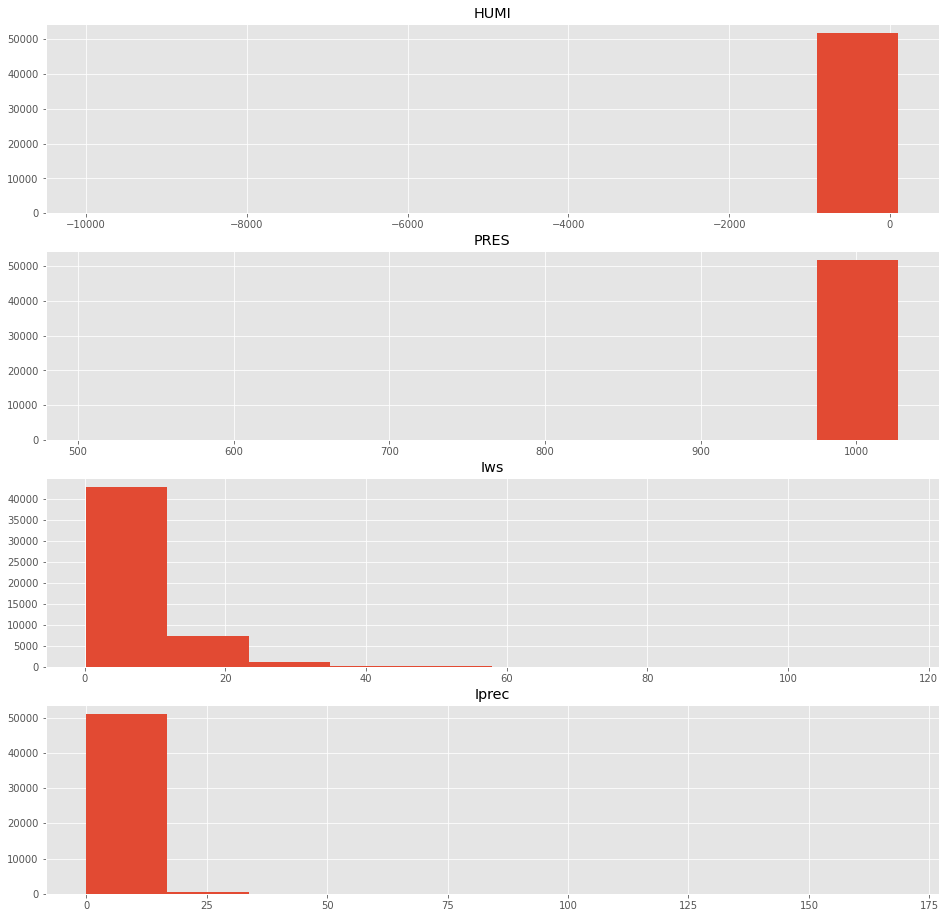

In [10]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16))
for i, col in enumerate(rec.dtype.names):
    ax[i].hist(rec[col])
    ax[i].set_title(col)

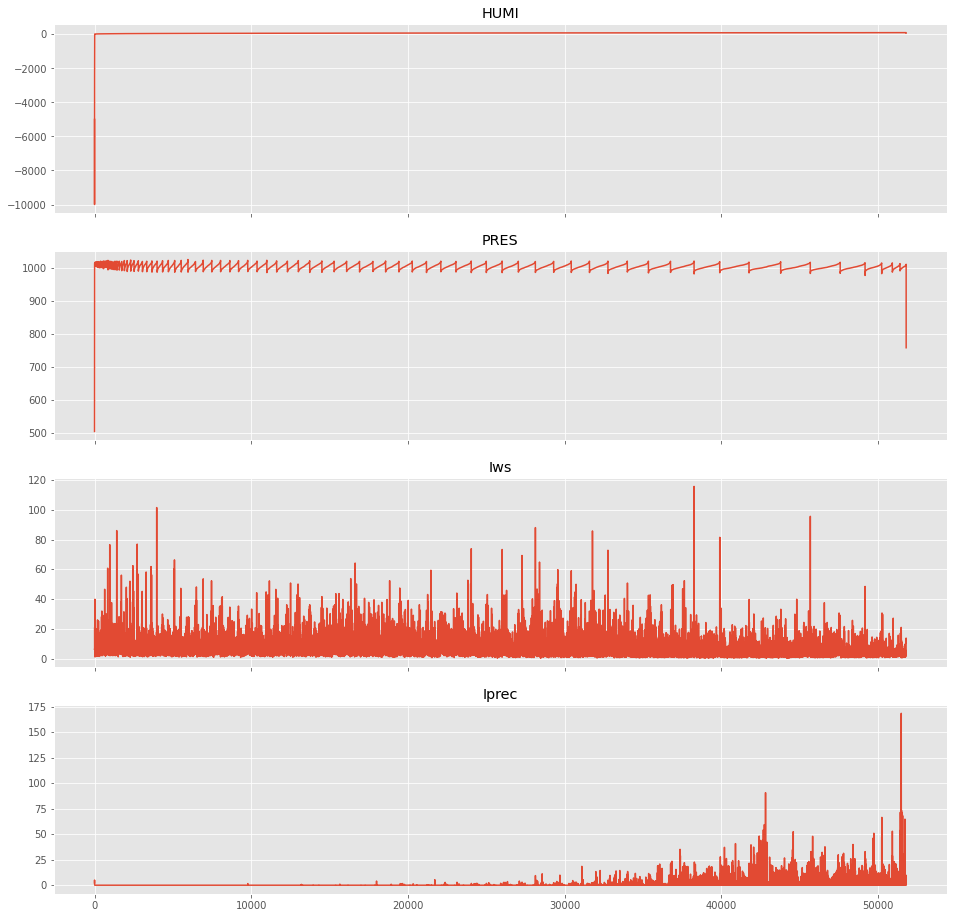

In [11]:
fig, ax = plt.subplots(rec.dtype.__len__(), 1, figsize = (16, 16), sharex=True)
for i, col in enumerate(rec.dtype.names):
    ax[i].plot(rec[col])
    ax[i].set_title(col)

In [12]:
# Pair Plot in matplotlib

## Standardization Normalization

In [13]:
rec_norm = rec.copy()

for i, col in enumerate(rec_norm.dtype.names):
    rec_norm[col] = (rec_norm[col] - rec_norm[col].mean()) / rec_norm[col].std()

## Covent Time-series format

In [16]:
def process_create_WindowTimeSeries(activity, df, activity_start, activity_len, time_window, n_feature, step_stride):
    df_series = df[df['class'] == activity].iloc[:,:-1][activity_start:(activity_start+activity_len)]
    segments = []
    labels = []

    for i in range(0, df_series.shape[0] - time_window, step_stride):
        df_series_feature = df_series.iloc[i: i + time_window]
        segments.append(df_series_feature.to_numpy())

    segments = np.asarray(segments)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_window, n_feature, 1)

    labels = np.repeat(activity, reshaped_segments.shape[0])

    return reshaped_segments, labels

In [17]:
activity_start = 0
activity_len = df.shape[0]
time_window = 100
n_feature = 36
step_stride = 10

X_3d = []
y_3d = []

for i in activity:
    reshaped_segments, labels = process_create_WindowTimeSeries(i, df, activity_start, activity_len, time_window, n_feature, step_stride)
    X_3d.append(reshaped_segments)
    y_3d.append(labels)
    
X_3d = np.concatenate(X_3d)
y_3d = np.concatenate(y_3d)

X_3d.shape, y_3d.shape

NameError: name 'df' is not defined

## One-Hot Encoder

In [18]:
n_feature = feature.shape[0]
one_hot = np.zeros((X.shape[0], X.shape[1], n_feature))
for i, unique_value in enumerate(np.unique(X)):
    one_hot[:, :, i][X == unique_value] = 1

X = one_hot.reshape(-1, n_feature*X.shape[1])

X.shape

NameError: name 'feature' is not defined

## Train & Test Split

In [ ]:
random_state = 0

np.random.seed(random_state)
np.random.shuffle(X)

np.random.seed(random_state)
np.random.shuffle(y)

X.shape, y.shape

In [14]:
train_size = 0.8
sample = int(train_split*y.shape[0])

X_train, X_test = X[:sample], X[sample:]
y_train, y_test = y[:sample], y[sample:]

X_train.shape, X_test.shape

NameError: name 'train_split' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 -train_size, random_state=42, stratify=y, shuffle=True)

X_train.shape, X_test.shape